In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import util
import game
import sys
from labellines import labelLine, labelLines

In [2]:
"""
Direi che la prima cosa da fare è spliceare i dati in modo da non avere roba inutile.
quello che voglio avere è :
item id, thread id, byr id, slr id, status, offr_price
"""
data = pd.read_csv("data/anon_bo_threads.csv",sep=',',usecols=['anon_item_id', 'anon_thread_id', 'anon_byr_id', 'anon_slr_id', 'offr_type_id', 'status_id', 'offr_price', 'src_cre_date'])

In [3]:
grouped_data = data.sort_values('anon_slr_id')
#grouped_data

In [4]:
reduced_data = grouped_data[(grouped_data['status_id'] != 6) & (grouped_data['status_id'] != 0)]
#reduced_data[:10]

In [5]:
#len(grouped_data.loc[grouped_data['anon_slr_id'] == 45])
multiplicity = reduced_data.groupby('anon_item_id').count()['anon_byr_id']
#multiplicity
#grouped_data.loc[37012993]['anon_slr_id']

In [6]:
multiplicity = multiplicity.sort_values(ascending = False)
#multiplicity.__class__.__name__
#multiplicity_reduced = multiplicity[(multiplicity >= 5) & (multiplicity <=10)]
multiplicity_reduced = multiplicity[multiplicity == 5]
#multiplicity_reduced[:10].index

In [85]:
class Game():

    def __init__(self, game):
        self._game = game.copy()
        self._buyers = np.unique(np.array(self._game['anon_byr_id']))
        self._seller = np.array(self._game['anon_slr_id'])[0]
        self._offers = self._game.sort_values('src_cre_date', ascending = True)[['anon_byr_id','offr_type_id','status_id','offr_price', 'src_cre_date']]
        self.id_map = {}
        self._n_buyers = len(self._buyers)
        for i in range(self._n_buyers):
            self.id_map[self._buyers[i]] = i

    def get_game(self):
        return self._game.copy()

    def get_seller(self):
        return self._seller.copy()

    def get_buyers(self):
        return self._buyers.copy()

    def get_offers(self):
        return self._offers.copy()

    def map_buyer(self, buyer):
        return self.id_map[buyer]

    def get_buyers_normalized(self):
        return np.array([self.map_buyer(x) for x in self._buyers])

    def get_seller_normalized(self):
        return (self._n_buyers - 1) / 2

    def get_winner(self):
        return self.id_map[np.array(self._game[self._game['status_id'] == 1]['anon_byr_id'])[0]]

    def get_n_buyers(self):
        return self._n_buyers

    def make_step():
        pass

In [8]:
def create_games(index, cur, df, output):
    output[cur] = Game(game=df.loc[df['anon_item_id'] == index])

v_create_games = np.vectorize(create_games, excluded=['df', 'output'])

In [86]:
NUM_GAMES = 1
games = np.empty((15,NUM_GAMES), dtype=list)
for j in range(5,20):
    sys.stdout.write("\rProgress: " + str((j-5) * 100 / 14) + "%")
    multiplicity_spliced = np.array(multiplicity[multiplicity == j][:NUM_GAMES].index)
    v_create_games(index=multiplicity_spliced, cur=range(NUM_GAMES), df=reduced_data, output=games[j-5])

Progress: 100.0%

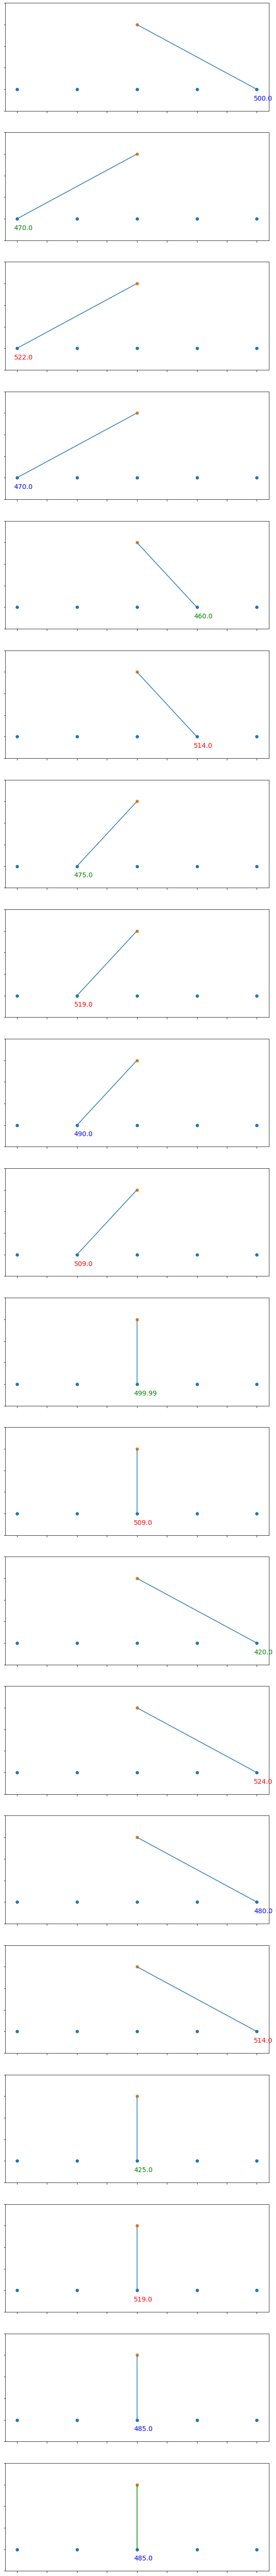

In [89]:
test_game = games[14][0]

offers = test_game.get_offers().replace(to_replace=test_game.id_map)

fig, axes = plt.subplots(nrows=len(offers) + 1, ncols=1, figsize=(10,(len(offers) + 1) * 5))
colors = ['g','b','r']
for offer, ax in zip(offers.iterrows(), axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #ax.axis('off')
    ax.scatter(test_game.get_buyers_normalized(), [1] * test_game.get_n_buyers())
    ax.scatter(test_game.get_seller_normalized(), [4])
    ax.plot([offer[1]['anon_byr_id'], test_game.get_seller_normalized()],[1, 4])
    ax.text(offer[1]['anon_byr_id']-0.05, 0.5, str(offer[1]['offr_price']), fontsize=14, color=colors[offer[1]['offr_type_id']])
    ax.set_ylim([0, 5])

axes[-1].set_xticklabels([])
axes[-1].set_yticklabels([])
axes[-1].scatter(test_game.get_buyers_normalized(), [1] * test_game.get_n_buyers())
axes[-1].scatter(test_game.get_seller_normalized(), [4])
axes[-1].plot([test_game.get_winner(), test_game.get_seller_normalized()],[1, 4], 'g')
axes[-1].text(test_game.get_winner()-0.05, 0.5, str(offer[1]['offr_price']), fontsize=14, color=colors[offer[1]['offr_type_id']])
axes[-1].set_ylim([0, 5])

#ax.set_xlabel(r'$\Delta_i$', fontsize=15)
#ax.set_ylabel(r'$\Delta_{i+1}$', fontsize=15)
#ax.set_title('Volume and percent change')

ax.grid(False)
#fig.tight_layout()
